https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time

In [3]:
import dask.dataframe as dd
import pandas as pd

In [57]:
df = pd.read_csv('flightdelays-2016-1.zip')

In [58]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445827 entries, 0 to 445826
Data columns (total 23 columns):
FL_DATE                445827 non-null object
UNIQUE_CARRIER         445827 non-null object
FL_NUM                 445827 non-null int64
ORIGIN                 445827 non-null object
ORIGIN_CITY_NAME       445827 non-null object
ORIGIN_STATE_ABR       445827 non-null object
ORIGIN_STATE_NM        445827 non-null object
DEST                   445827 non-null object
DEST_CITY_NAME         445827 non-null object
DEST_STATE_ABR         445827 non-null object
DEST_STATE_NM          445827 non-null object
CRS_DEP_TIME           445827 non-null int64
DEP_DELAY              434354 non-null float64
CRS_ARR_TIME           445827 non-null int64
ARR_DELAY              433298 non-null float64
CANCELLED              445827 non-null float64
DIVERTED               445827 non-null float64
CARRIER_DELAY          70882 non-null float64
WEATHER_DELAY          70882 non-null float64
NAS_DELAY     

In [12]:
df.groupby('ORIGIN_STATE_NM')['WEATHER_DELAY'].mean().nlargest(5)

ORIGIN_STATE_NM
North Dakota           14.737113
New Hampshire          11.804878
Tennessee              10.927152
U.S. Virgin Islands     9.941667
Georgia                 7.968872
Name: WEATHER_DELAY, dtype: float64

In [13]:
df['DEP_DELAY'].mean()

7.7935370688424648

In [19]:
daily = df.set_index(pd.to_datetime(df['FL_DATE'])).resample("D")
daily['DEP_DELAY'].mean().max()

17.208583194855862

In [18]:
df.loc[df['DEP_DELAY'] > 0,'FL_NUM'].count()

149141

In [23]:
daily = df.set_index(pd.to_datetime(df['FL_DATE']))
daily.loc[daily['DEP_DELAY']>0].resample("D")['FL_NUM'].count().mean()

4811.0

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

during the the summer and winter, 40% of flights per day are delayed on average

In [37]:
%%time
avg_delayed = []
for month in range(1,13):
    # read
    df = pd.read_csv('flightdelays-2016-{}.zip'.format(month), index_col='FL_DATE', parse_dates=True)
    
    # process
    total_flights = df.resample('D')['FL_NUM'].count()
    delayed = df.loc[df['DEP_DELAY']>0]
    frac_delayed = delayed.resample('D')['FL_NUM'].count() / total_flights
    
    avg_delayed.append(frac_delayed.mean() * 100)

CPU times: user 20.4 s, sys: 2.05 s, total: 22.5 s
Wall time: 22.5 s


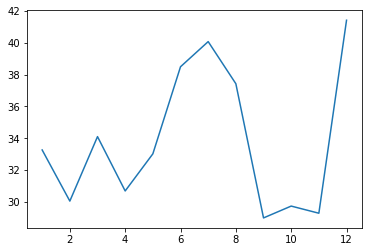

In [39]:
plt.plot(range(1,13), avg_delayed)

In [54]:
from dask import delayed

@delayed
def read_one(file):
    df = pd.read_csv(file, index_col='FL_DATE', parse_dates=True)
    return df

@delayed
def percent_delayed(df):
    total_flights = df.resample('D')['FL_NUM'].count()
    delayed_flights = df.loc[df['DEP_DELAY']>0]
    frac_delayed = delayed_flights.resample('D')['FL_NUM'].count() / total_flights
    return frac_delayed.mean() * 100

@delayed
def mean(flights):
    return sum(flights) / len(flights)

In [42]:
avg_delayed = []
for month in range(1,13):
    df = read_one('flightdelays-2016-{}.zip'.format(month))
    avg_delayed.append(percent_delayed(df))
    

CPU times: user 1.36 ms, sys: 276 µs, total: 1.64 ms
Wall time: 1.52 ms


In [46]:
avg_delayed[0]

Delayed('percent_delayed-062d596c-e331-4a1b-baa4-7d40d6f5a8ce')

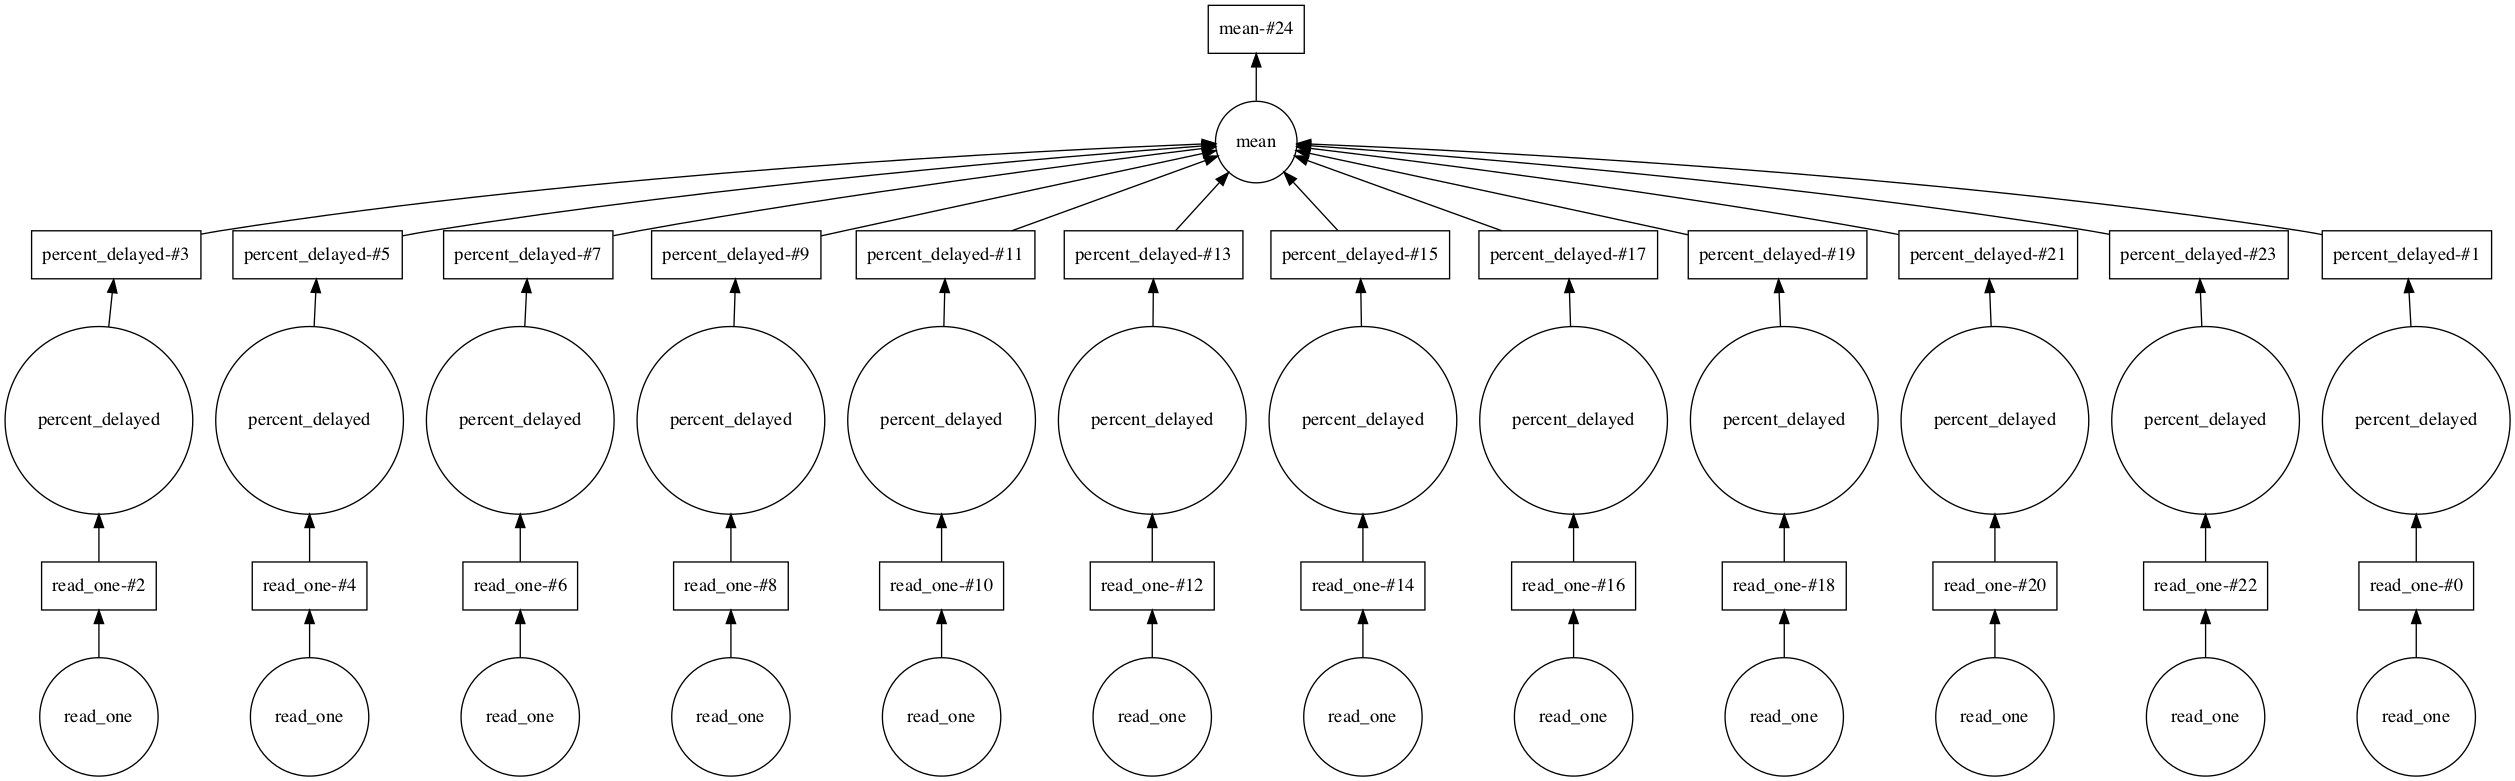

In [52]:
mean(avg_delayed).visualize()

In [44]:
from dask import compute

In [55]:
%%time
mean(avg_delayed).compute()

CPU times: user 23.8 s, sys: 3.21 s, total: 27 s
Wall time: 12.9 s


33.874576385714526

In [45]:
compute(avg_delayed)

([33.259421196788658,
  30.047534674572233,
  34.097539024271391,
  30.68344436363174,
  33.015218846509576,
  38.487168244947625,
  40.066803207407816,
  37.421014717477512,
  28.989535816112316,
  29.733490287839974,
  29.284134923645698,
  41.40961132536976],)